
# Hate Speech Detection par classification

In [1]:
import pandas as pd
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_files = r"/content/drive/MyDrive/Data_M/dataset_fr/"

In [4]:
training_dataset = pd.read_csv(f"{path_files}fr_dataset.csv")

In [5]:
clean_dataset_min= pd.read_fwf(f"{path_files}dataset_frMin")

In [6]:
clean_dataset_std= pd.read_fwf(f"{path_files}dataset_frStd")

In [7]:
clean_dataset_lem= pd.read_fwf(f"{path_files}dataset_frLem")

In [8]:
clean_dataset_min.head(10)

,tweet
0,rt user personnage ainsi q tte la clique gauch...
1,user user user bah oui t'as raison l'autre c'e...
2,moi j'ai personne à qui m'adresser pour réclam...
3,user user c ... est vrai que les anchois sont ...
4,eh les renois faut se réveiller la url
5,user user en algerie les migrants sont expulsé...
6,user sjw et féministe twitter un sale combo
7,user user tu sais aussi pourquoi est au dessus...
8,user user mytho t'as juste voulu te faire ken ...
9,c’est un giga attardé mdrrr ils va vraiment se...


In [9]:
# Ajout de la longueur du texte en tant que variable dans le jeu de données 
training_dataset['text length'] = training_dataset['tweet'].apply(len)

training_dataset.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,direct,shock,origin,other,128
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,indirect,shock,other,individual,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,direct,anger_confusion_sadness_fear_disgust,other,women,120
3,4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other,102
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent,39


In [10]:
#Obtenir les datatypes des colonnes 
training_dataset.dtypes

HITId                   int64
tweet                  object
sentiment              object
directness             object
annotator_sentiment    object
target                 object
group                  object
text length             int64
dtype: object

In [11]:
#Vérifier s'il n'y a pas de valeur nulle qui se trouve dans le dataset 
import numpy as np
np.sum(training_dataset.isnull().any(axis=1))

0

In [12]:
print('Nombre de tweets dans le dataset:', len(training_dataset))

Nombre de tweets dans le dataset: 4014


## Cleaning des tweets 

In [13]:
#vérifier les target values uniques 
training_dataset['sentiment'].unique()

array(['abusive', 'offensive', 'hateful', 'normal',
       'fearful_abusive_offensive_hateful_normal', 'abusive_offensive',
       'offensive_hateful', 'disrespectful', 'offensive_disrespectful',
       'fearful', 'fearful_abusive_hateful',
       'fearful_abusive_offensive_normal',
       'fearful_abusive_disrespectful_normal', 'abusive_normal',
       'fearful_normal', 'offensive_normal', 'disrespectful_normal',
       'abusive_offensive_hateful_normal', 'abusive_offensive_hateful',
       'fearful_abusive_offensive_disrespectful_normal',
       'abusive_disrespectful', 'offensive_hateful_disrespectful_normal',
       'hateful_normal', 'abusive_offensive_hateful_disrespectful',
       'abusive_offensive_disrespectful', 'fearful_disrespectful_normal',
       'abusive_offensive_hateful_disrespectful_normal',
       'fearful_abusive', 'abusive_disrespectful_normal',
       'abusive_hateful', 'fearful_abusive_disrespectful_hateful_normal',
       'abusive_offensive_disrespectful_normal',

On remarque qu'il y a beaucoup de target (classes), 64 classes .

On commence par enlever les colonnes qui ne nous interessent pas dans le cadre de notre étude, et ne laisser que la colonne sentiment

In [14]:
data_hate = training_dataset.drop(['directness', 'annotator_sentiment', 'target', 'group'], axis=1)
data_hate.head()

,HITId,tweet,sentiment,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,128
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,120
3,4,@user @user c...est vrai que les anchois sont ...,normal,102
4,5,eh les renois faut se réveiller la @url,normal,39


Dans ce qui suit , quand le sentiment est "normal" il sera etiqueté à 0, sinon  1, ce qui aboutira un problème de classification binaire .

C'est une première stratégie pour essayer de construire un modèle capable de reconnaitre les tweets haineux.

Éttiquetage des données pour obtenir un problème de classification binaire

In [15]:
#Convertir les valeurs string de la colonne « Sentiment » en format binaire, c'est-à-dire soit « 0 » pour normal et « 1 » pour hateful 
data_hate['sentiment'] = data_hate['sentiment'].map(lambda sentiment: 0 if sentiment == 'normal' else 1)
data_hate['sentiment'] = data_hate['sentiment'].astype(int)
data_hate.head()

,HITId,tweet,sentiment,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120
3,4,@user @user c...est vrai que les anchois sont ...,0,102
4,5,eh les renois faut se réveiller la @url,0,39


In [16]:
# isoler les sentiments targets du fichier csv dans une variable nommée Y
Y = data_hate['sentiment']

print(Y)

0       1
1       1
2       1
3       0
4       0
       ..
4009    1
4010    1
4011    1
4012    0
4013    1
Name: sentiment, Length: 4014, dtype: int64


Ajouter les différentes variantes de nettoyage du dataset

In [17]:
data_hate['clean_tweet_min']=clean_dataset_min

In [18]:
data_hate['clean_tweet_std']=clean_dataset_std

In [19]:
data_hate['clean_tweet_lem']=clean_dataset_lem

In [20]:
data_hate.head(10)

,HITId,tweet,sentiment,text length,clean_tweet_min,clean_tweet_std,clean_tweet_lem
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,rt user personnage ainsi q tte la clique gauch...,rt user personnag tte cliqu gauchist deguis 1 ...,rt user personnage tout cliqu gauchiste deguis...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,user user user bah oui t'as raison l'autre c'e...,user user user raison mongol.,user user user raison mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...,m'adress réclam. voisin attard pu brui adminis...,me adresser réclamer. voisin attarder puant br...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,user user c ... est vrai que les anchois sont ...,user user ... vrai anchois aller lun invent mi...,user user ... vrai anchois aller lune invent m...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la url,renois faut réveil url,renois falloir réveiller url
5,6,@user @user en algerie les migrants sont expul...,1,112,user user en algerie les migrants sont expulsé...,user user alger migr expuls désert crois bien ...,user user algerie migrant expulser désert croi...
6,7,@user sjw et féministe twitter un sale combo,0,44,user sjw et féministe twitter un sale combo,user sjw fémin twitt sal combo,user sjw féministe twitter sale combo
7,8,@user @user tu sais aussi pourquoi est au dess...,0,101,user user tu sais aussi pourquoi est au dessus...,user user sais? veut ya d'ani ... url,user user sai? vouloir ya de ani ... url
8,9,@user @user mytho t'as juste voulu te faire ke...,1,105,user user mytho t'as juste voulu te faire ken ...,user user mytho voulu fair ken renois lyc voul...,user user mytho vouloir faire ken renois lycer...
9,10,c’est un giga attardé mdrrr ils va vraiment se...,1,64,c’est un giga attardé mdrrr ils va vraiment se...,gig attard mdrrr va fair shoot url,giga-octet attarder mdrrr aller faire shoote url


In [21]:
def nettoie(string):
  data_hate[string] = data_hate[string].apply(lambda x : ' '.join([tweet for tweet in x.split()if not (tweet == "user" or tweet=="rt" or tweet=="url")]))

In [24]:
nettoie('clean_tweet_min')
nettoie('clean_tweet_std')
nettoie('clean_tweet_lem')

In [25]:
data_hate.head()

,HITId,tweet,sentiment,text length,clean_tweet_min,clean_tweet_std,clean_tweet_lem
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,personnage ainsi q tte la clique gauchiste deg...,personnag tte cliqu gauchist deguis 1 macron!!...,personnage tout cliqu gauchiste deguise 1 macr...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est un mongol.,raison mongol.,raison mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...,m'adress réclam. voisin attard pu brui adminis...,me adresser réclamer. voisin attarder puant br...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c ... est vrai que les anchois sont aller sur ...,... vrai anchois aller lun invent million tech...,... vrai anchois aller lune invent million tec...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la,renois faut réveil,renois falloir réveiller


In [26]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

## Analyse exploratoire des données

In [35]:
#Nuage des mots associés aux tweets non haineux 
"""
fonction pour visualiser les mots les plus fréquents
paramètres:
  - string = chaine représentant le nom de la variante
  - label: titre de la figure
  - num: etiquette cible 0 ou 1
Sortie : un plot wordcloud
"""
def plot_wrdcloud(string,num):
  normal_words = ' '.join([word for word in data_hate[string][data_hate['sentiment'] == num]])
  wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
  if (num == 0): 
    print("Tweets Normaux") 
  else: 
    print("Tweets Haineux")
  plt.figure(figsize= (12,8))
  plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
  plt.axis('off')

Tweets Normaux


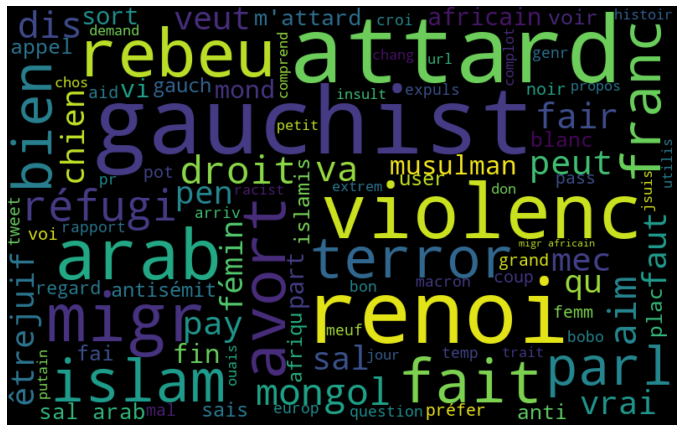

In [37]:
plot_wrdcloud('clean_tweet_std', 0)

Tweets Normaux


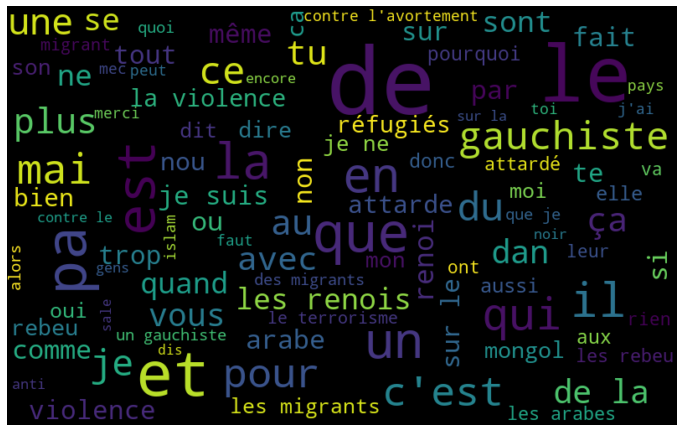

In [38]:
plot_wrdcloud('clean_tweet_min', 0)

Concernant la version Min dans laquelle nous n'avons pas supprimmer les stopwords , on retrouve beaucoup de ceux ci dans notre nuage de mots .

Tweets Haineux


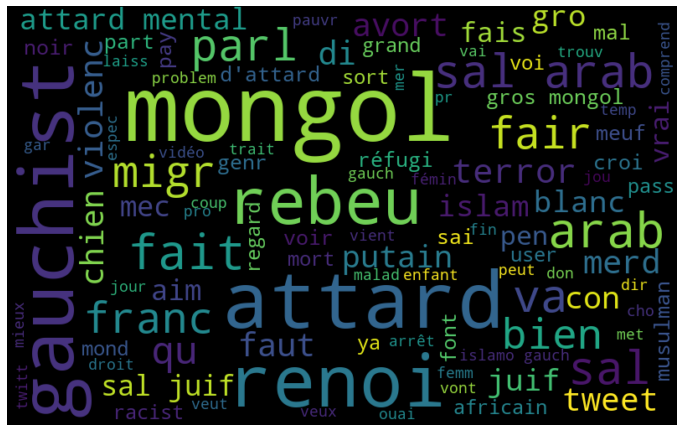

In [39]:
plot_wrdcloud('clean_tweet_std', 1)

On remarque que dans les deux nuages de mots , que ce soit celui représentant les tweets haineux et les tweets normaux , le vocabulaire fréquent est similaire , ce qui rendra encore plus difficile la détection des deux classes.

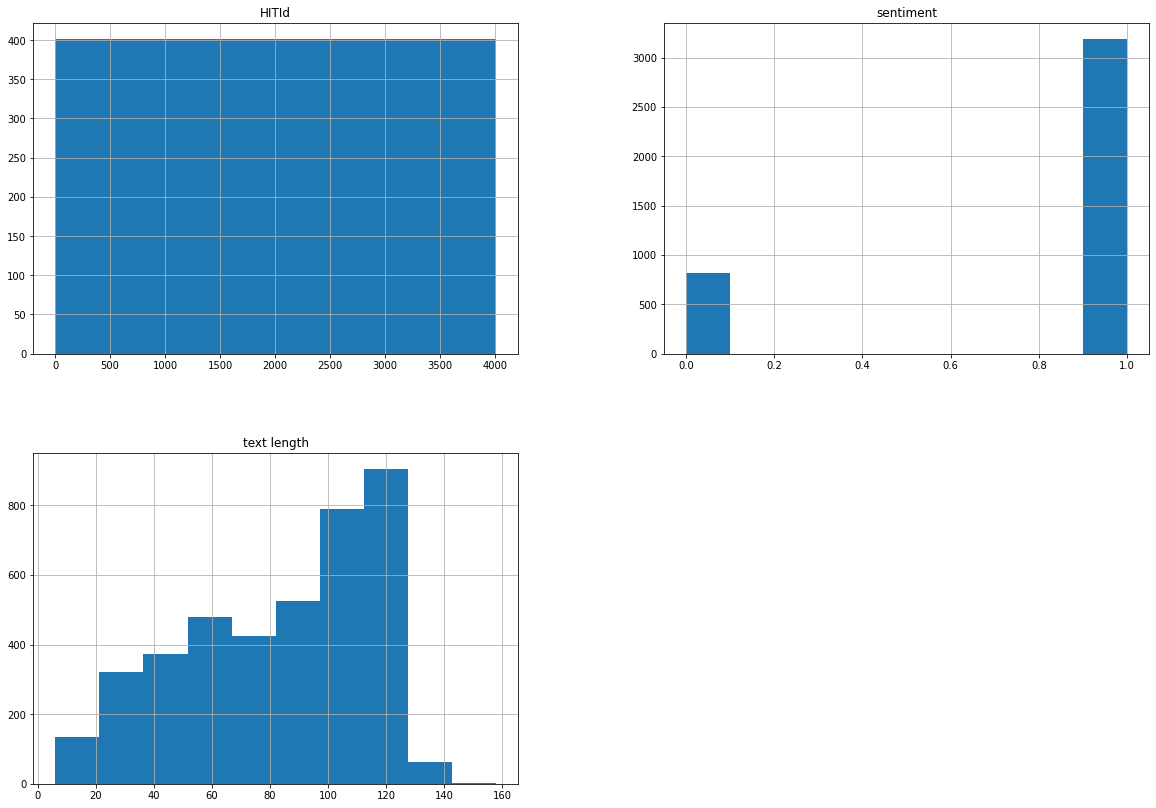

In [40]:
_ = data_hate.hist(figsize=(20, 14))

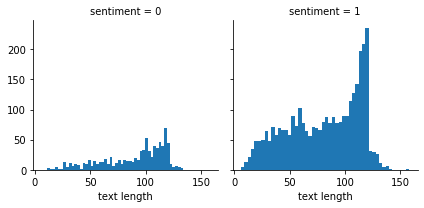

In [41]:
#Visualisation du text lenght à l'aide d'histogrammes
#FacetGrid - Grille multi-plot pour visualiser des relations conditionnelles
graph = sns.FacetGrid(data=data_hate, col='sentiment')
graph.map(plt.hist, 'text length', bins=50)

On constate que la distribution de la longueur des tweets semble presque être similaire dans les deux classes : tweets neutres (0) vs. tweets haineux (1).

On ne peut donc considérer la longueur du tweet comme une variable determinante dans notre classification .

## Balancement des classes 

Text(0.5, 1.0, 'Distribution des tweets')

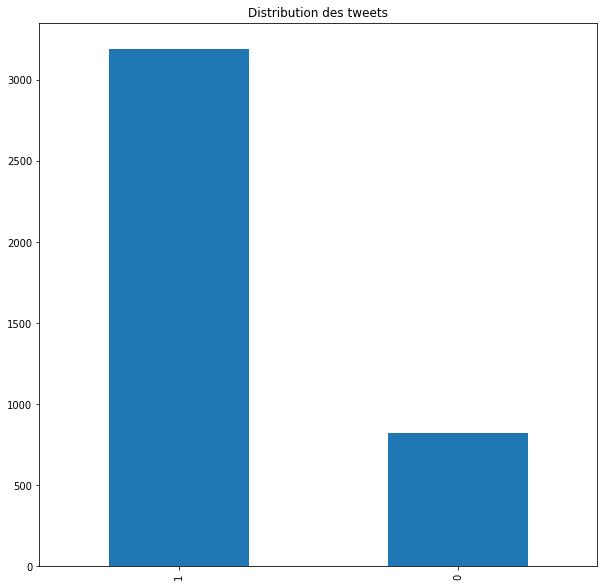

In [42]:
plt.figure(figsize=(10, 10))

data_hate.sentiment.value_counts().plot(kind='bar').set_title('Distribution des tweets')


In [43]:
#Pourcentage de la proportion de tweets neutres vs. haineux.
print("Neutres: ", data_hate.sentiment.value_counts()[0]/len(data_hate)*100,"%")
print("Haineux: ", data_hate.sentiment.value_counts()[1]/len(data_hate)*100,"%")

Neutres:  20.453413054309916 %
Haineux:  79.5465869456901 %


Le graphique ci-haut démontre que les données d'entraînement ne sont pas parfaitement équilibrées, la classe "1" (hateful speech) a environ 3 fois plus de données que la classe "0" (normal). 

In [44]:
data_hate.to_pickle(f"{path_files}data_hate.pkl")